In [1]:
import torch 
from torch import nn, Tensor
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

In [3]:
def get_reward(x):
    '''
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5
    '''
    x_cor = x[:,0]
    y_cor = x[:,1]
    # print(x_cor, y_cor.shape)
    outer = (x_cor**2 + y_cor**2)
    outer_reward = 1-abs(outer.cpu().detach().numpy() - 1) 
    inner = ((x_cor-1)**2 + (y_cor-0.5)**2)
    inner_reward = 1-abs(inner.cpu().detach().numpy() - 1)
    reward = np.maximum(outer_reward, inner_reward) 
    return reward

In [4]:
flow = Flow().to('cuda')

state_dict = torch.load('flow.pth')
flow.load_state_dict(state_dict)



/tmp/ipykernel_451748/883044107.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('flow.pth')


<All keys matched successfully>

0.18582475 0.9994823
0.87501323


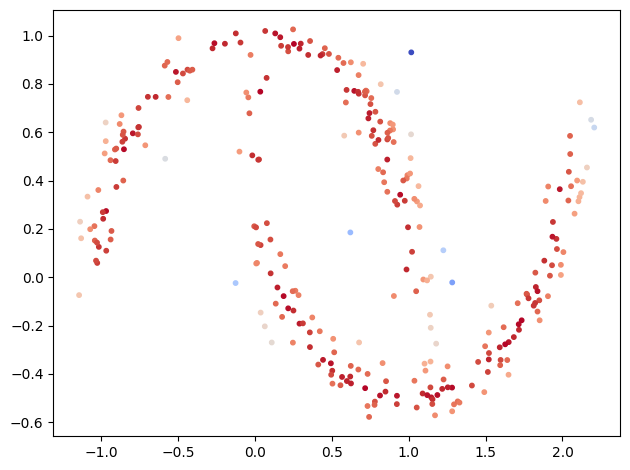

In [5]:
x = torch.randn(300, 2)
n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1)
for i in range(n_steps):
    x = flow.step(x_t=x.to('cuda'), t_start=time_steps[i].to('cuda'), t_end=time_steps[i + 1].to('cuda'))

rewards = get_reward(x)
print(min(rewards), max(rewards))
print(np.mean(rewards))
# scatter plot with the color of the reward (cmap: red to blue) 0 is red, 1 is blue
plt.scatter(x.cpu().detach()[:, 0], x.cpu().detach()[:, 1], s=10, c=rewards, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [6]:
from ppo import PPO
ppo_agent = PPO(policy=flow, state_dim=2, lr_actor=1e-4, lr_critic=1e-2, gamma=0.99, K_epochs=10, eps_clip=0.1, n_steps=n_steps,action_std_init=0.1)


In [7]:
import copy
device = 'cuda'
class Environment:
    def __init__(self):
        self.state = None
        self.reward = None
        self.done = None
        self.timestep = 0
        self.batch_size = 64
        self.max_timesteps = 8

    def reset(self):
        self.state = np.random.randn(self.batch_size, 2)
        self.ori = copy.deepcopy(self.state)
        self.reward = 0
        self.done = False
        self.timestep = 0
        return self.state

    def step(self):
        states = []
        log_probs = []
        state_values = []
        self.sample_num = 50
        time_steps = torch.linspace(0, 1.0, self.max_timesteps + 1)
        for i in range(self.max_timesteps):
            self.timestep += 1
            states.append(copy.deepcopy(self.state))
            next_state,log_prob, state_val = ppo_agent.select_action(torch.FloatTensor(self.state).to(device), time_steps[i].to(device),time_steps[i+1].to(device) )
            self.state = next_state
            log_probs.append(log_prob)
            state_values.append(state_val)
        state_ori = torch.Tensor(self.ori).to(device)
        for i in range(self.max_timesteps):
            state_ori = ppo_agent.original_policy.step(state_ori, time_steps[i].to(device), time_steps[i+1].to(device))
        # plt.figure()
        # plt.scatter(state_ori[:,0].cpu().detach().numpy(), state_ori[:,1].cpu().detach().numpy())
        # plt.show()
        reward = get_reward(torch.Tensor(next_state).to(device))
        distance = np.linalg.norm(state_ori.detach().cpu().numpy() - next_state, axis=1)
        reward -= distance/20
        states = np.array(states) # [T x B x D]
        log_probs = np.array(log_probs)
        state_values = np.array(state_values)
        self.reward = reward 
        return states, next_state, log_probs, state_values, reward

In [8]:
max_training_timesteps = 50 #100
update_timestep = 1
# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0
action_std_decay_freq = 5
action_std_decay_rate = 1e-2
min_action_std = 1e-5
print_freq = 1
gamma = 0.99
env = Environment()
ppo_agent.buffer.clear()
# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    states, generated, log_probs, state_values, reward = env.step()
    done = True
    print(log_probs.shape, state_values.shape)
    # saving reward and is_terminals
    flow_time_steps = torch.linspace(0, 1.0, n_steps + 1)
    for i in range(env.batch_size):
        ppo_agent.buffer.logprobs.append(torch.FloatTensor([log_probs[:-1,i]]).to(device))
        ppo_agent.buffer.state_values.append(torch.FloatTensor([state_values[:-1,i,0]]).to(device))
        ppo_agent.buffer.states.append(torch.FloatTensor(states[:-1,i]).to(device))
        ppo_agent.buffer.actions.append(torch.FloatTensor(states[1:,i]).to(device))
        ppo_agent.buffer.rewards.append(reward[i])
        # discount reward
        # discounted_reward = gamma**(n_steps - t) * reward[i]
        # ppo_agent.buffer.rewards.append(discounted_reward)
        ppo_agent.buffer.is_terminals.append(done)
    
    time_step +=1
    current_ep_reward += reward.mean()
    # update PPO agent
    if time_step % update_timestep == 0:
        if time_step > 50: ppo_agent.start_actor = True
        ppo_agent.update()
        ppo_agent.buffer.clear()
        ppo_agent.policy_old.load_state_dict(ppo_agent.policy.state_dict())

    if time_step % action_std_decay_freq == 0:
        ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

    # printing average reward
        # print average reward till last episode
    print_avg_reward = round(current_ep_reward, 2)

    print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

    print_running_reward = 0
    print_running_episodes = 0

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


(8, 64) (8, 64, 1)


/tmp/ipykernel_451748/1158964232.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  ppo_agent.buffer.logprobs.append(torch.FloatTensor([log_probs[:-1,i]]).to(device))


Episode : 0 		 Timestep : 1 		 Average Reward : 0.7099999785423279
(8, 64) (8, 64, 1)
Episode : 1 		 Timestep : 2 		 Average Reward : 0.7300000190734863
(8, 64) (8, 64, 1)
Episode : 2 		 Timestep : 3 		 Average Reward : 0.7699999809265137
(8, 64) (8, 64, 1)
Episode : 3 		 Timestep : 4 		 Average Reward : 0.7799999713897705
(8, 64) (8, 64, 1)
--------------------------------------------------------------------------------------------
setting actor output action_std to :  0.09
--------------------------------------------------------------------------------------------
Episode : 4 		 Timestep : 5 		 Average Reward : 0.7599999904632568
(8, 64) (8, 64, 1)
Episode : 5 		 Timestep : 6 		 Average Reward : 0.7699999809265137
(8, 64) (8, 64, 1)
Episode : 6 		 Timestep : 7 		 Average Reward : 0.8100000023841858
(8, 64) (8, 64, 1)
Episode : 7 		 Timestep : 8 		 Average Reward : 0.8100000023841858
(8, 64) (8, 64, 1)
Episode : 8 		 Timestep : 9 		 Average Reward : 0.8199999928474426
(8, 64) (8, 64, 

0.9234045


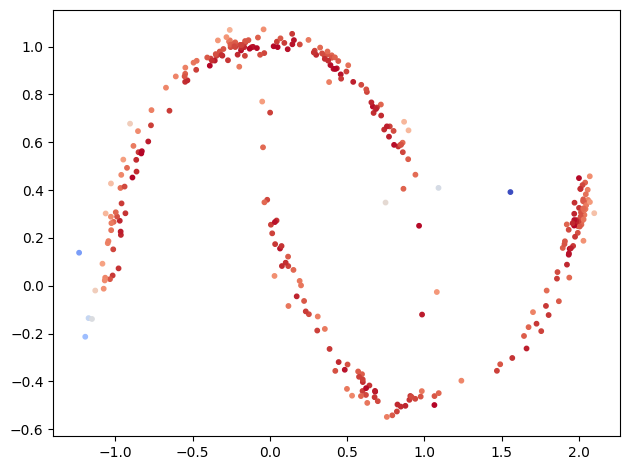

In [11]:
x = torch.randn(300, 2)
n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1)
for i in range(n_steps):
    x = ppo_agent.policy.actor.step(x_t=x.to('cuda'), t_start=time_steps[i].to('cuda'), t_end=time_steps[i + 1].to('cuda'))

rewards = get_reward(x)
print(np.mean(rewards))
# scatter plot with the color of the reward (cmap: red to blue) 0 is red, 1 is blue
plt.scatter(x.cpu().detach()[:, 0], x.cpu().detach()[:, 1], s=10, c=rewards, cmap='coolwarm')
# plt.xlim(-2, 2.5)
# plt.ylim(-0.7, 1.25)
plt.tight_layout()
plt.show()

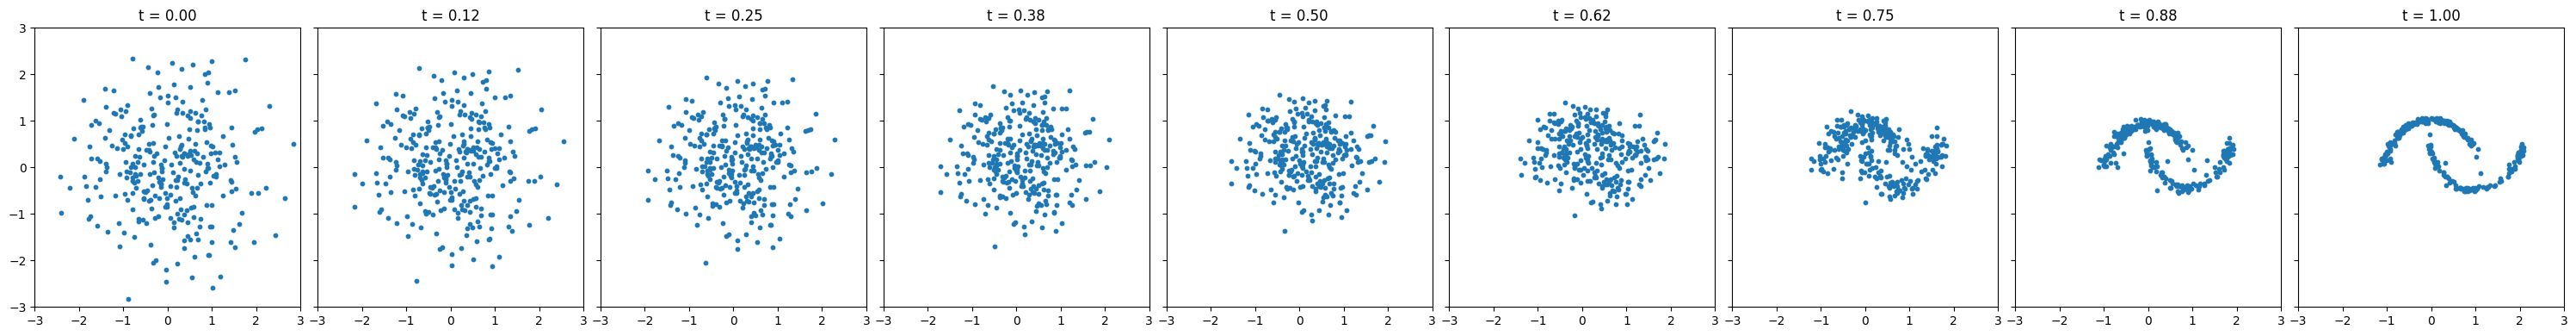

In [10]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x.to('cuda'), t_start=time_steps[i].to('cuda'), t_end=time_steps[i + 1].to('cuda'))
    axes[i + 1].scatter(x.cpu().detach()[:, 0], x.cpu().detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()